## Makine Öğrenimi Projesi Bölüm-2

Bu çalışma örneğimizde "denetimli(supervised)" bir regresyon makinesi öğrenme problemi üzerinde çalışıyoruz. Gerçek dünyadaki New York şehrinin bina enerji verilerini kullanarak, bir binanın Enerji Yıldız Puanını tahmin etmek ve Yıldız Puanı'nı etkileyen faktörleri belirlemek istiyoruz.

Projemizi yapılandırmak için makine öğrenmesi aşamalarının genel taslağını kullanıyoruz:

     1. Veri temizleme ve biçimlendirme
     2. Keşifsel veri analizi
     3. Özellik mühendisliği ve seçimi
     4. Bir performans metriğinde çeşitli makine öğrenim modellerinin karşılaştırılması
     5. Problem için optimize etmek üzere en iyi modele hiperparametre ayarlaması yapılması
     6. Test seti üzerinde en iyi modelin değerlendirilmesi
     7. Model sonuçlarının mümkün olduğu kadar yorumlanması
     8. Sonuçların görselleştirilip ve iyi bir raporun yazılması
     
Serinin ilk bölümü yukarıda belirtilen adımların 1-2-3'ünü kapsıyordu ve bu çalışmada 4-5-6'yı ele alacağız. Bu çalışmada, detaylardan ziyade uygulamalara daha çok odaklanıyoruz ve makine öğrenme yöntemleri konuları ile ilgili daha fazla detay arayanlar için, Aurelien Geron tarafından Scikit-Learn ve Tensorflow ile Hands-On Machine Learning  kitaplarını incelemelerini öneririm. Bu, algoritmaların arkasındaki temel teori için mükemmel bir kaynak ve bunları Python'da nasıl etkin bir şekilde kullanacaksınız bunları güzel bir şekilde açıklıyor!

[Link ->](http://shop.oreilly.com/product/0636920052289.do)

İlgili Kütüphaneleri ekleyerek projemizi kodlamaya başlıyoruz:

Bu projede standart veri bilimi ve makine öğrenmesi kütüphanelerini kullanacağız.

In [1]:
#Verilerin işlenmesi için Pandas ve Numpy kütüphanelerini öncelikle ekliyoruz
import pandas as pd
import numpy as np

#Bölümler arasında hata uyarısı almamak için uyarıları kapatıyoruz
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

#Görselleştirme için Matplotlib  ve seaborn kütüphanelerini ekliyoruz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 2)

#Varsayılan font boyutunu belirtiyoruz
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

#Eksik değerleri ve ölçekleme değerlerini ekliyoruz
from sklearn.preprocessing import Imputer, MinMaxScaler

#Makine Öğrenmesi Modellerini ekliyoruz
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#Hiperparametre ayarlaması
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Verileri Okuyoruz
Bir önceki çalışmamızdan edindiğimiz verileri okuyoruz

In [4]:
# Veriçerçevesinden verileri okuyoruz
train_features = pd.read_csv('../saitalay/Projeler/VeriBilimi/Kaggle/NYC-ENERGY_WATER- STAR Score/training_features.csv')
test_features = pd.read_csv('../saitalay/Projeler/VeriBilimi/Kaggle/NYC-ENERGY_WATER- STAR Score/testing_features.csv')
train_labels = pd.read_csv('../saitalay/Projeler/VeriBilimi/Kaggle/NYC-ENERGY_WATER- STAR Score/training_labels.csv')
test_labels = pd.read_csv('../saitalay/Projeler/VeriBilimi/Kaggle/NYC-ENERGY_WATER- STAR Score/testing_labels.csv')

# Verilerin boyutlarını yazdırıyoruz
print('Eğitim verileri özellik boyutu: ', train_features.shape)
print('Test verileri özellik boyutu:  ', test_features.shape)
print('Eğitim etiketleri boyutu:  ', train_labels.shape)
print('Test etiketleri boyutu:   ', test_labels.shape)

Eğitim verileri özellik boyutu:  (6622, 64)
Test verileri özellik boyutu:   (2839, 64)
Eğitim etiketleri boyutu:   (6622, 1)
Test etiketleri boyutu:    (2839, 1)


Bir hatırlatma olarak, biçimlendirilmiş verilerin neye benzediğini burada bulabilirsiniz. İlk çalışma örneğinde, değişkenlerin doğal günlüğünü alarak, iki kategorik değişken içeren bir dizi özellik geliştirdik ve yüksek değerli özellikleri kaldırarak bir özellik alt kümesi seçtik.

In [5]:
#Eğitim setindeki  özellik değerlerinin ilk 12 satırını görüntülüyoruz
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

Puan(Score) sütunu, makine öğrenim problemimiz için hedef olan Energy Yıldız Puanını içerir. Enerji Yıldız Puanının, bir binanın enerji verimliliğinin karşılaştırmalı bir ölçümü olduğu varsayılsa da, bunun birinci bölümde nasıl hesaplandığıyla ilgili sorunlar olabileceğini görmüştük!

İşte Energy Yıldız Puanının dağılımı

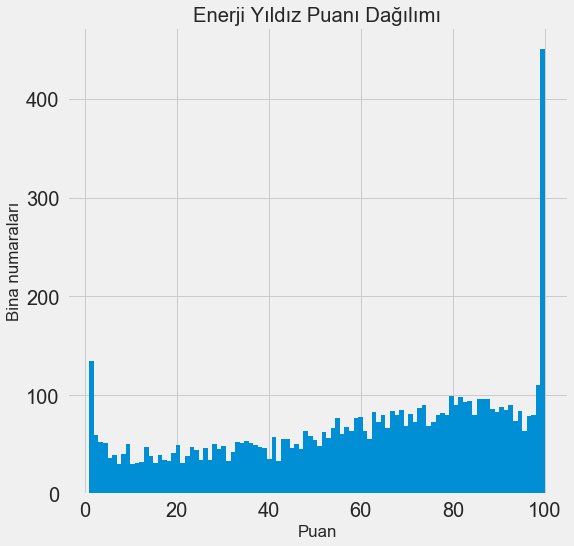

In [6]:
figsize(8, 8)

#Enerji Yıldız Puanının Histogramı
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100)
plt.xlabel('Puan');
plt.ylabel('Bina numaraları');
plt.title('Enerji Yıldız Puanı Dağılımı');

### Makine Öğrenim Modellerini Değerlendirme ve Karşılaştırma
Bu bölümde, denetimli regresyon görevimiz için çeşitli makine öğrenme yöntemleri oluşturup, eğitecek ve değerlendireceğiz. Amaç, geliştirme için hangi modelin daha fazla faydalı olduğunu belirlemektir (hiperparametre ayarı gibi).

Modelleri ortalama mutlak hata(MAE) metriğini kullanarak karşılaştırıyoruz. Puanın medyan değerini tahmin eden bir taban çizgisi modeli ortalama 25 puan olarak belirlendi.

### Eksik Değerleri Etkilemek
Standart makine öğrenim modelleri eksik değerlerle baş edemez ve bu da eksik değerleri olan herhangi bir özelliği doldurmak veya atmak için bir yol bulmamız gerektiği anlamına gelir. İlk kısımda% 50'den fazla eksik değer içeren özellikleri zaten kaldırdığımızdan, burada bu eksik değerleri doldurmaya odaklanacağız. Yerine koyma için bir dizi yöntem var ama burada eksik değerleri sütunun ortancası ile değiştirmenin nispeten basit bir yöntemini kullanacağız. 

Aşağıdaki kod da, eksik değerleri sütunun medyanı ile doldurmak için bir "Scikit Learn Imputer" nesnesi oluşturuyoruz. Eğitim verisine (imputer.fit yöntemini kullanarak)değil, test verisine dikkat çektiğimizi fark etmişsinizdir. Daha sonra hem eğitim verilerini hem de test verilerini dönüştürürüz (Imputer.transform kullanarak). Bu, test setindeki eksik değerlerin, eğitim setindeki ilgili sütunlarını medyan değeri ile doldurulduğu anlamına gelir. Bu şekilde yapmalıyız, çünkü konuşlandırma zamanında, önceki değerleri önceki eğitim verilerine dayanarak yeni gözlemlerde eksik değerler olarak kabul etmek zorundayız. Bu, test setindeki bilginin eğitim sürecine "sızdığı" veri sızıntısı olarak bilinen problemden kaçınmanın bir yoludur.

In [7]:
#Medyan doldurma stratejisi ile bir imputer nesnesi oluşturuyoruz
imputer = Imputer(strategy = 'median')

#Eğitim özellikleri üzerine uyguluyoruz
imputer.fit(train_features)

#Eğitim Ve Test verilerini dönüştürüyoruz
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [8]:
print('Eğitim verileri içerisindeki kayıp değerler: ', np.sum(np.isnan(X)))
print('Test verileri içerisindeki kayıp değerler:  ', np.sum(np.isnan(X_test)))

Eğitim verileri içerisindeki kayıp değerler:  0
Test verileri içerisindeki kayıp değerler:   0


In [9]:
#Bütün Değerlerin sonlu olarak işlendiğinden emin olalım
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


Denemeden sonra, tüm özellikler gerçek değerlidir. Daha sofistike yöntemler için (medyan değerler genellikle iyi çalışıyor olsa da) bu makaleyi inceleyebilirsiniz. 
[Link](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146)

### Ölçekleme Özellikleri
Modellerimizi kurabilmemiz için atmamız gereken son adım, özellikleri ölçeklendirmektir. Özelliklerin farklı birimlerde olması nedeniyle bu gereklidir, özellikleri normalleştirmek ve birimlerin algoritmayı etkilememesi için bunu yapmak gerekiyor. Doğrusal Regresyon ve Rastgele Orman(Random Forest) özellik ölçekleme gerektirmez, ancak destek vektör makineleri(SVM) ve k yakın komşuları(kMeans) gibi diğer yöntemler, gözlemler arasındaki öklid mesafesini hesaba kattığı için bunu gerektirir. Bu nedenle, çoklu algoritmaları karşılaştırırken özellikleri ölçeklemek en iyi uygulamadır.

Özellikleri ölçeklendirmenin iki yolu vardır:

    1. Her bir değer için, özelliğin ortalamasını çıkarın ve özelliğin standart sapmasına bölün. Bu standardizasyon olarak bilinir ve her özellik ortalama 0'a ve standart sapmaya 1 sahiptir.
    2. Her bir değer için, özelliğin minimum değerini çıkartın ve maksimum eksi (özellik) için en düşük değere bölün. Bu durum, bir özellik için tüm değerlerin 0 ile 1 arasında olmasını ve bir aralık veya normalleştirmeye ölçeklendirilmesini sağlar.
    
İşte normalleşme ve standardizasyon hakkında [iyi bir makale](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/)

Ölçüde olduğu gibi, ölçekleme nesnesini eğitirken sadece eğitim setini kullanmak istiyoruz. Özellikleri dönüştürdüğümüzde, hem eğitim setini hem de test setini değiştireceğiz.

In [10]:
#0-1 değerlerinde bir ölçeklendirme nesnesi oluşturuyoruz
scaler = MinMaxScaler(feature_range=(0, 1))

#Eğitim Verilerine uyguluyoruz
scaler.fit(X)

#Eğitim ve Test Verilerini dönüştürüyoruz
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [11]:
# Y'yi tek boyutlu vektöre dönüştürüyoruz
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

### Değerlendirilecek Modeller
Harika Scikit-Learn kütüphanesini kullanarak beş farklı makine öğrenim modelini karşılaştıracağız:

    1.Doğrusal Regresyon(Linear Regression)
    2.Destek Vektör Makinesi Regresyon(Support Vector Machine)
    3.Rastgele Orman Regresyonu(Random Forest Regression)
    4.Eğim Artırıcı Regresyon(Gradient Boosted REgression)
    5.K-En Yakın Komşular Regresyonu(K-Nearest Neighbors Regression)

Yine burada, bu modellerin nasıl çalıştığını açıklamak yerine uygulamaya odaklanıyoruz. Makine Öğrenim Modeline ek olarak, ekteki kaynağın faydalı olabileceğini düşünüyorum.(bu ücretsizdir), [İstatistiksel Öğrenmeye Giriş](http://www-bcf.usc.edu/~gareth/ISL/)


Modelleri karşılaştırmak  ve model hipermetreleri için çoğunlukla Scikit-Learn varsayılanlarını kullanacağız. Genel olarak bunlar düzenli bir performans sergileyecek, ancak bir model kullanmadan önce optimize edilmelidir. İlk başta, her modelin temel performansını belirlemek istiyoruz ve daha sonra hiperparametre ayarını kullanarak daha fazla optimizasyon için en iyi performans modelini seçiyoruz. Varsayılan hiperparametrelerin bir model oluşturup çalışacağını hatirlayalım, ancak problemimizde en iyi ayarları bulmak için hemen hemen her zaman bir çeşit arama kullanılarak  ilgili parametreler ayarlanmalıdır!

İşte Scikit-learn belgelerinin varsayılanlar hakkında söylediği şey:

__Sensible defaults__: Bir işlem her kullanıcı tarafından tanımlanmış bir parametre gerektirdiğinde,
uygun bir varsayılan değer, kütüphane tarafından tanımlanır. Varsayılan değer
operasyonun mantıklı bir şekilde gerçekleştirilmesine neden olmalıdır (Eldeki görev için çözüm.)

Scikit-learn kütüphanesinin en iyi yönlerinden biri, tüm modellerin aynı şekilde uygulanmış olmasıdır: bir kez nasıl inşa edeceğinizi bildikten sonra, çok çeşitli modeller dizisi uygulayabilirsiniz. Burada sadece birkaç satırlık kod ile bir dizi model için tüm eğitim ve test prosedürlerini uygulayacağız.

In [12]:
#Mutlak Ortalama Hata(MAE) hesaplama foksiyonu
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

#Bir Model alıp, modeli eğitip, hesplayıp ve test edeceğiz
def fit_and_evaluate(model):
    #Modeli Eğitiyoruz
    model.fit(X, y)
    
    #Modeli Tahmin edip hesaplıyoruz
    model_pred = model.predict(X_test)
    model_mae =mae(y_test, model_pred)
    
    #Performans metriğine geri dönüyoruz
    return model_mae

In [13]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Test Verileri üzerinde Doğrusal Regrasyon Performansı : MAE = %0.4f' % lr_mae)

Test Verileri üzerinde Doğrusal Regrasyon Performansı : MAE = 13.4651


In [14]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Test Verileri üzerinde Destek Vektör makinesi Regrasyon Performansı : MAE = %0.4f' % svm_mae)

Test Verileri üzerinde Destek Vektör makinesi Regrasyon Performansı : MAE = 10.9337


In [15]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Test Verileri üzerinde Rastgele Orman Regrasyon Performansı : MAE = %0.4f' % random_forest_mae)

Test Verileri üzerinde Rastgele Orman Regrasyon Performansı : MAE = 10.0147


In [16]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Test Verileri üzerinde Eğim Artırıcı Regresyon Performansı MAE = %0.4f' % gradient_boosted_mae)

Test Verileri üzerinde Eğim Artırıcı Regresyon Performansı MAE = 10.0132


In [17]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('Test verileri üzerinde K-Nearest Neighbors(En Yakın Komşu) Regression Performansı : MAE = %0.4f' % knn_mae)

Test verileri üzerinde K-Nearest Neighbors(En Yakın Komşu) Regression Performansı : MAE = 13.0131


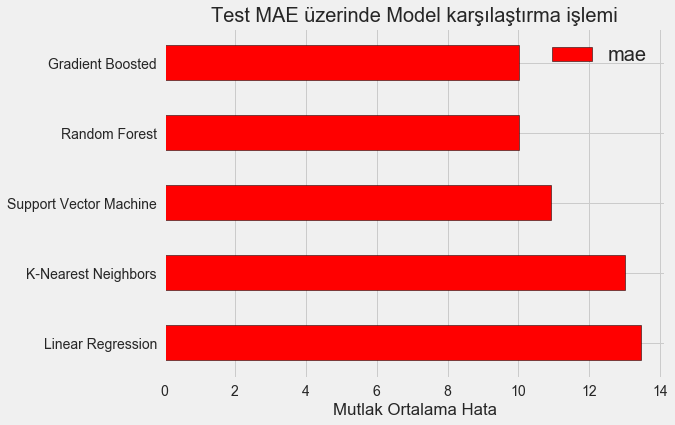

In [18]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

#Sonuçları veriçerçevesinde tutuyoruz
model_comparison = pd.DataFrame({'model' : ['Linear Regression', 'Support Vector Machine',
                                            'Random Forest', 'Gradient Boosted', 'K-Nearest Neighbors'],
                                'mae' : [lr_mae, svm_mae, random_forest_mae, gradient_boosted_mae,
                                        knn_mae]})
#Test mae için Yatay  grafik çubuğu 
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

#Biçimlendirme işlemini çizdiriyoruz
plt.ylabel('');
plt.yticks(size = 14); 
plt.xlabel('Mutlak Ortalama Hata'); plt.xticks(size = 14)
plt.title('Test MAE üzerinde Model karşılaştırma işlemi', size = 20);

Koşula bağlı olarak (tam sonuçlar her seferinde hafifçe değişir), gradyan(eğim) artırma regresörü en iyi olanı rasgele ormanı izler. Bunun en adil karşılaştırma olmadığını kabul etmeliyim, çünkü çoğunlukla varsayılan hipermetreler kullanıyoruz. Özellikle Destek Vektör Regresörü ile hipermetreler, performans üzerinde önemli bir etkiye sahiptir. (rastgele orman ve eğim(gradient) yükseltme yöntemleri, performansın model ayarlarına daha az bağımlı olması nedeniyle başlatılmak için mükemmeldir). Bununla birlikte, bu sonuçlardan, makine modelinin uygulanabilir olduğu sonucuna varabiliriz çünkü tüm modeller ana hattan önemli ölçüde daha iyi performans gösterir!

Buradan, hyperparameter ayarını kullanarak en iyi modeli optimize etmeye konsantre olacağız. Buradaki sonuçlar göz önüne alındığında, GradientBoostingRegressor'u kullanmaya konsantre olacağız. Bu, son birkaç yılda birçok Kaggle yarışmalarını kazanan Gradient Boosted Trees'ın Scikit-Learn uygulamasıdır. Scikit-Learn sürümü genellikle XGBoost versiyonundan daha yavaştır, ancak burada söz dizimi daha tanıdık olduğundan Scikit-Learn'e bağlıyız. İşte, XGBoost paketinde uygulamayı kullanmak için birkaç link.

[link XGBoost](http://matthewemery.ca/Why-Kagglers-Love-XGBoost/),
[link Gradient Boosting](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf),
[link Kaggle Eğitim](https://www.kaggle.com/dansbecker/learning-to-use-xgboost)

### Model Optimizasyonu
Makine öğrenmesinde, bir modeli optimize etmek, belirli bir problem için en iyi hipermetre setini bulmak anlamına gelir.

##### Hiper Parametreler(Hyperparameters)
İlk olarak, model hipermetrelerinin ve model parametrelerinin ne olduğunu anlamaya ihtiyacımız var:

   - Model hipermetreleri, eğitimden önce veri bilimcisi tarafından ayarlanan bir makine öğrenme algoritması ayarları olarak düşünülür. Örnekler rastgele ormandaki ağaç sayısı veya K En Yakın Komşular Regresyonunda kullanılan komşuların sayısı olabilir.
   - Model parametreleri, modelin doğrusal regresyondaki ağırlıklar gibi eğitim sırasında neler öğrendiğidir.
   
Veribilimcilerin bir modeli hiperparametreleri seçerek kontrol etmelerini sağlıyoruz ve bu seçimler, modelin nihai performansı üzerinde önemli bir etkiye sahip olabilir (genellikle daha fazla veri veya mühendislik özelliği elde etmek gibi bir etki kadar büyük olmamakla birlikte).

Modelin hipermetrelerinin ayarlanması, bir modelde birbirine geçmenin dengesini kontrol eder. Rasgele bir ormanda daha fazla ağaç kullanmak veya derin bir sinir ağında daha çok katman kullanmak gibi daha karmaşık bir model oluşturarak yetersiz uyumu düzeltmeye çalışabiliriz. Uygun bir model, yüksek önyargıya sahiptir ve modelimiz, özellikler ve hedef arasındaki ilişkiyi öğrenmek için yeterli kapasiteye (serbestlik derecesi) sahip olmadığı zaman ortaya çıkar. Modelin karmaşıklığını sınırlandırarak ve düzenli hale getirerek aşırı donatmayı düzeltmeye çalışabiliriz. Bu, bir polinom regresyonunun derecesinin azaltılması ya da derin nöral bir ağa bırakma katmanlarının eklenmesi anlamına gelebilir. Overfits bir modelin yüksek varyansı vardır ve aslında eğitim setini ezberlemiştir. Hem underfitting hem de overfitting, test setindeki zayıf genelleme performansına yol açar.

Hiperparametrelerin seçilmesindeki problem, hiçbir setin tüm sorunlarda en iyi sonuç vermeyeceğidir. Bu nedenle, her yeni veri kümesi için en iyi ayarları bulmamız gerekiyor. Bu, zaman alıcı bir süreç olabilir, ancak neyse ki bu prosedürü Scikit-Learn'de gerçekleştirmek için birkaç seçenek vardır. Daha da iyisi, epistasis laboratuarları tarafından TPOT gibi yeni kütüphaneler, sizin için otomatik olarak bu işlemi yapmayı hedefliyor! Şimdilik, bunu Scikit-Learn'de manuel olarak yapmaya devam edeceğiz, ancak otomatik model seçimi ile ilgili bir makale için [link](https://epistasislab.github.io/tpot/)

## Rastgele Arama ve Çapraz Doğrulama ile Hipermetre Ayarı
Rastgele arama ve çapraz doğrulama yoluyla bir model için en iyi hiperparametreleri seçebiliriz.

Rastgele arama, değerlendirmek için hipermetreler seçtiğimiz yöntemi ifade eder: bir dizi seçenekleri tanımlar ve sonra denemek için rasgele kombinasyonları seçeriz. Bu, belirttiğimiz her bir kombinasyonu değerlendiren grid aramanın tersidir. Genel olarak, rastgele arama, en iyi model hipermetrelerle ilgili sınırlı bilgiye sahip olduğumuzda daha iyidir ve seçenekleri daraltmak için rasgele aramayı kullanabilir ve ardından daha sınırlı bir seçenek aralığına sahip grid aramasını kullanabiliriz.

Çapraz doğrulama, hiperparametrelerin performansını değerlendirmek için kullanılan yöntemdir. Eğitim setini, kullanabileceğimiz eğitim verilerinin miktarını azaltan ayrı eğitim ve doğrulama setlerine ayırmak yerine, K-Fold Cross Validation'ı kullanıyoruz. Bu, eğitim verilerinin K katlarına bölünmesi ve daha sonra kıvrımların K-1'i üzerinde ilk önce eğitim yaptığımız ve daha sonra kth katındaki performansı değerlendirdiğimiz yinelemeli bir süreçten geçmesi anlamına gelir. Bu süreci K kere tekrarlıyoruz, sonuç olarak, eğitim verisinde her örnek üzerinde test ettiğimiz her bir testin, üzerinde durmadığımız veriler üzerinde test ettiğimiz anahtarla test edeceğiz. K-katlama çapraz doğrulamasının sonunda, son ivme ölçüsü olarak K tekrarlamalarının her birinde ortalama hatayı alıp, tüm eğitim verilerinin modelini bir kerede eğitiyoruz. Kaydettiğimiz performans daha sonra hiperparametrelerin farklı kombinasyonlarını karşılaştırmak için kullanılır. K = 5 kullanılarak k-kat çapraz doğrulamanın bir resmi aşağıda gösterilmiştir:

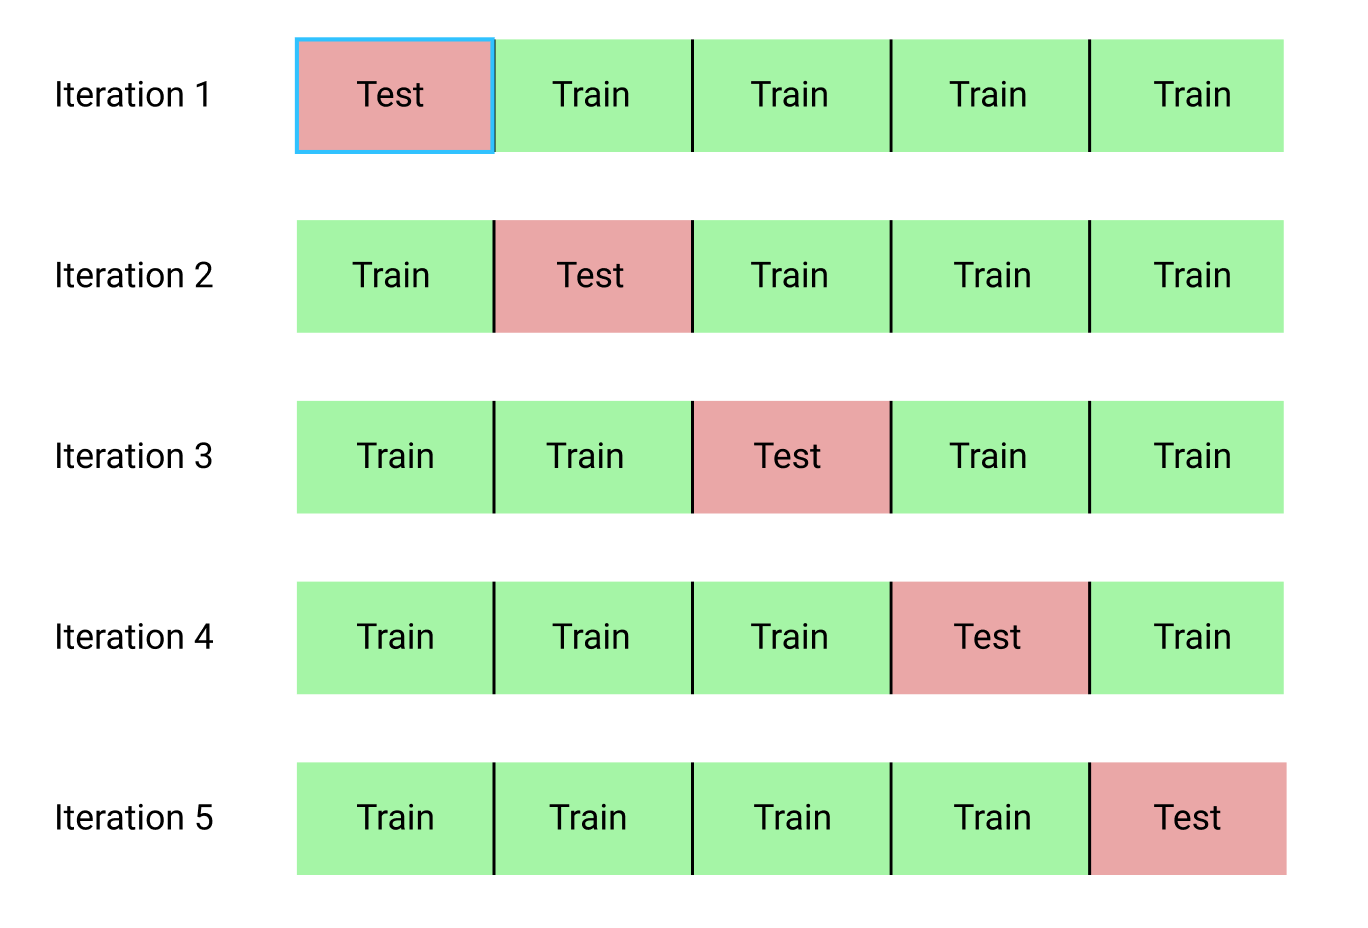

Burada gradyan artırma regresörü ve optimal hiperparametreler seçmek için çapraz doğrulama ile rasgele arama uygulayacağız. Öncelikle bir ızgarayı(grid) tanımlarız ve sonra bu durum tekrarlayan bir süreç oluşturur: Şebekeden rasgele bir hiperparametreler kümesini örneklenir, 4-kat çapraz doğrulama kullanarak hiperparametreleri değerlendirlendirilir ve daha sonra en iyi performans ile hiperparametreler seçilir.

Elbette bu yinelemeyi kendimiz yapmıyoruz, Scikit-Learn ve RandomizedSearchCV'nin bizim için süreci yapmasına izin veriyoruz!

In [19]:
#Kayıp Fonksiyonu optimize(en uygun hale getiriyoruz)
loss = ['ls', 'lad', 'huber']

#Artırma işleminde kullanılan  ağaç sayısı
n_estimators = [100, 500, 900, 1100, 1500]

#Her bir ağacın maksimum derinliği
max_depth =[2, 3, 5, 10, 15]

#Her bir yaprak için minimum örnek sayısı
min_samples_leaf = [1, 2, 4, 6, 8]

#node'lardan ayrılan örneklerin minimum  numaraları
min_samples_split = [2, 4, 6, 10]

# Bölümleri yapmak  için dikkate alınacak maksimum özellik sayısı
max_features = ['auto', 'sqrt', 'log2', None]

#Hiperparemetreleri aramak için bir grid tanımlıyoruz
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

Eğim artırıcı regresörü ayarlamak için 6 farklı hiperparametre seçtik. Bunların hepsi, modelin zamanını önceden belirlemenin zor olduğu farklı şekillerde etkileyecek ve belirli bir problem için en iyi kombinasyonu bulmanın tek yolu onları test etmektir! Hipermetreler hakkında bilgi edinmek için, Scikit-Learn belgelerine bir göz atmanızı öneriyorum. Şimdilik, en iyi hipermetreler kombinasyonunu bulmaya çalıştığımızı ve bize en iyi çalışacakları bir teori olmadığından, sadece bir deneme yapmak gibi bunları değerlendirmemiz gerektiğini biliyoruz.

Kodumuz ile, aşağıdaki parametrelerden geçen Randomized Search Object'i oluşturuyoruz.

    tahmincisi: model
    param_distributions: tanımladığımız parametrelerin dağılımı
    k katlama: çapraz doğrulaması için kullanılacak kat sayısı
    n_iter: denenecek farklı kombinasyonların sayısı
    puanlama: adayları değerlendirirken kullanılacak metrik
    n_jobs: paralel olarak çalışacak çekirdek sayısı (-1 tüm uygun olanlar kullanılabilir)
    ayrıntılı: görüntülenecek ne kadar bilgi (1 sınırlı bir miktar gösterir)
    return_train_score: her çapraz doğrulama katlaması için eğitim puanını döndür
    random_state: kullanılan rasgele sayı üreticisini düzeltir, böylece her koşuda aynı sonuçları alırız

Randomize Arama Nesnesi, diğer scikit-learn modelleriyle aynı şekilde eğitilmiştir. Eğitimden sonra, tüm farklı hiperparametre kombinasyonlarını karşılaştırabilir ve en iyi performansa sahip olanı bulabiliriz.

In [22]:
#Hiperparametre ayarlamak için bir model oluşturuyoruz
model = GradientBoostingRegressor(random_state = 42)

#4-fold çapraz doğrulama için rastgele aramayı ayarlıyoruz
random_cv = RandomizedSearchCV(estimator = model,
                              param_distributions = hyperparameter_grid,
                              cv = 4, n_iter = 25,
                              scoring = 'neg_mean_absolute_error',
                              n_jobs = -1, verbose = 1,
                              return_train_score = True,
                              random_state = 42)

In [23]:
# Eğitim verisine uyguluyoruz
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.1min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

Scikit-learn, değerlendirme için negatif ortalama mutlak hatasını kullanır çünkü bir metriği en üst düzeye çıkarmak ister. Bu nedenle, daha iyi bir puan 0'a yakın olacaktır. Rastgele arama sonuçlarını bir veri çerçevesine alabiliriz ve değerleri performansa göre sıralayabiliriz.

In [24]:
#Bütün Cv sonuçlarını alıp test performanslarına göre sıralıyoruz
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)
random_results.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
12,20.099643,0.027143,-8.998761,-6.893790,lad,5,None,6,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",1,-8.859381,-7.027368,-8.773966,-6.837958,-9.325139,-6.869084,-9.036779,-6.840749,0.366181,0.004341,0.210901,0.078077
3,17.760894,0.023140,-9.041004,-4.465253,huber,5,None,8,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",2,-8.868788,-4.482073,-8.904791,-4.326121,-9.315304,-4.823009,-9.075321,-4.229809,0.344522,0.001336,0.176509,0.225313
9,10.895170,0.016841,-9.192518,-6.987506,huber,3,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",3,-9.134318,-7.007604,-9.042461,-7.088986,-9.441179,-6.913108,-9.152240,-6.940327,0.117614,0.001085,0.149456,0.067939
0,3.313818,0.007908,-9.196413,-7.293554,ls,5,auto,6,2,100,"{'n_estimators': 100, 'min_samples_split': 2, ...",4,-9.101610,-7.302003,-9.026912,-7.312645,-9.456259,-7.173397,-9.201033,-7.386171,0.083862,0.001433,0.162211,0.076569
7,10.909861,0.018366,-9.350555,-7.073741,ls,3,auto,6,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",5,-9.146159,-7.089709,-9.199358,-7.103749,-9.699696,-7.021418,-9.357220,-7.080088,0.852116,0.002051,0.215966,0.031358
10,88.829344,0.101499,-9.376652,-0.400401,huber,10,None,6,10,1100,"{'n_estimators': 1100, 'min_samples_split': 10...",6,-9.261256,-0.378166,-9.243867,-0.459465,-9.528538,-0.393491,-9.473096,-0.370483,2.386886,0.011942,0.125816,0.035092
19,27.426594,0.039183,-9.381693,-8.202307,lad,3,auto,2,6,1100,"{'n_estimators': 1100, 'min_samples_split': 6,...",7,-9.379335,-8.311796,-9.382576,-8.658903,-9.473980,-7.820534,-9.290880,-8.017995,0.982954,0.005204,0.064740,0.316303
2,52.868306,0.055286,-9.419115,-0.165987,huber,10,auto,2,4,500,"{'n_estimators': 500, 'min_samples_split': 4, ...",8,-9.385744,-0.164859,-9.288317,-0.193613,-9.572674,-0.164415,-9.429825,-0.141062,1.436357,0.005989,0.102366,0.018629
16,32.325471,0.050185,-9.446787,-4.801009,ls,3,None,6,4,1500,"{'n_estimators': 1500, 'min_samples_split': 4,...",9,-9.246573,-4.821677,-9.317156,-4.876202,-9.798950,-4.776650,-9.424668,-4.729506,0.484158,0.003239,0.212942,0.054284
21,6.528988,0.029281,-9.460295,-5.666205,huber,5,log2,4,6,500,"{'n_estimators': 500, 'min_samples_split': 6, ...",10,-9.393840,-5.684121,-9.289175,-5.742441,-9.750806,-5.571781,-9.407503,-5.666476,0.816158,0.004099,0.173829,0.061337


In [25]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

En iyi eğim artırma modeli(gradient boosted model) aşağıdaki parametreler ile elde ediliyor:

loss = lad
n_estimators = 500
max_depth = 5
min_samples_leaf = 6
min_samples_split = 6
max_features = None (This means that max_features = n_features according to the docs)

Rastgele arama kullanmak, denemek için olası hiperparametreleri daraltmak adına iyi bir yöntemdir. Başlangıçta, hangi kombinasyonun en iyi işe yarayacağı hakkında hiçbir fikrimiz yoktu, ama bu en azından seçeneklerimizi  azaltıyor.

Rastgele arama sonuçları, rasgele arama sırasında en iyi çalışanlara yakın hipermetrelerle bir grid oluşturarak bir şebeke aramasını bildirmek için kullanabiliriz. Ancak, tüm bu ayarları tekrar değerlendirmek yerine, ormandaki ağaçlara (n_estimatörler)'e yani tek bir noktaya odaklanacağım. Sadece bir hiperparametre değiştirerek, performansı nasıl etkilediğini doğrudan gözlemleyebiliriz. Ağaçların sayısının fazla olması durumunda, aşırı havaya kaçma miktarında önemli bir etki görmeyi bekliyoruz.

Burada sadece n_estimators hiperparametreye sahip bir grid ile ızgara arama(grid search) kullanacağız. Bir dizi ağaç değerlendireceğiz ve daha sonra modelimizin ağaç sayısını arttırmanın ne olduğuna dair bir fikir edinmek için eğitim ve test performansını çizdirelim. Ağaç etkisinin sayısını azaltmak için diğer hiperparametrelerin rasgele aramayla döndürülen en iyi değerlere sabitlenmesini sağlayacağız.

In [26]:
#Ağaçları hesaplamak için bir aralık belirliyoruz
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                              min_samples_leaf = 6,
                              min_samples_split = 6,
                              max_features = None,
                              random_state = 42)

#Ağaç aralığını ve rastgele orman modelini kullanan Izgara Arama Nesnesi
grid_search = GridSearchCV(estimator = model, param_grid = trees_grid, cv = 4,
                          scoring = 'neg_mean_absolute_error', verbose = 1,
                          n_jobs = -1, return_train_score = True)

In [27]:
#grid search uyarlıyoruz
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.5min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

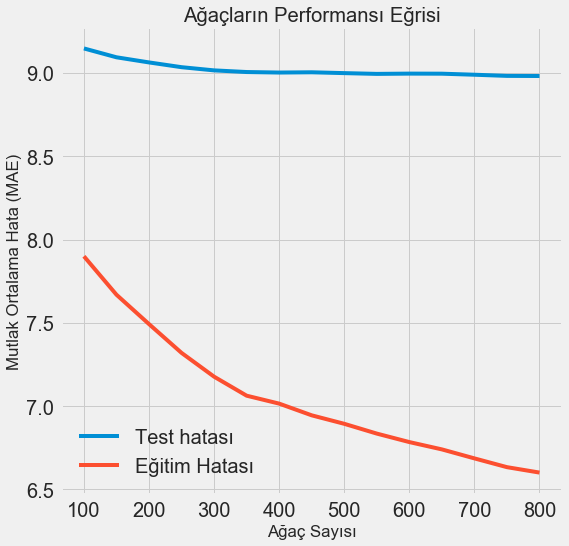

In [29]:
#Veri seti içindeki sonuçları alıyoruz
results = pd.DataFrame(grid_search.cv_results_)

# Ağaç sayılarının eğitim ve test hatalarının çizdiriyoruz
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Test hatası')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Eğitim Hatası')
plt.xlabel('Ağaç Sayısı'); plt.ylabel('Mutlak Ortalama Hata (MAE)'); plt.legend();
plt.title('Ağaçların Performansı Eğrisi');

results.sort_values('mean_test_score', ascending = False).head(5)

Bu sonuçlarda, modelimizin aşırı derecede uygun olduğu gayet açık! Eğitim hatası, test hatasından önemli ölçüde daha düşüktür, bu da modelin eğitim verilerini çok iyi öğrendiğini, ancak test verilerini de genelleştiremediğini gösterir. Taşınma, ağaç sayısı arttıkça, aşırı yakma miktarı artar. Ağaç sayısı arttıkça hem test hem de eğitim hatası azalır, ancak eğitim hatası daha hızlı azalır.

Eğitim hatası ile test hatası arasında her zaman bir fark olacaktır (eğitim hatası her zaman daha düşüktür), fakat eğer önemli bir fark varsa, daha fazla eğitim verisi alarak ya da modelin karmaşıklığını azaltarak aşırı hatayı denemek ve azaltmak istiyoruz. Hiperparametre ayarlaması veya düzenlenmesi ile eğim artırıcı regresör için, bazı seçenekler; ağaç sayısını azaltmak, her ağacın maksimum derinliğini azaltmak ve bir yaprak düğümündeki minimum örnek sayısını arttırmaktır. Gradient artırma regresörü için daha fazla bilgi edinmek isteyen herkes için harika bir makale aşağıda verilmiştir. Şimdilik modeli en iyi performansla kullanacağız ve eğitim setine yakışabileceğini kabul edeceğiz.

Çapraz doğrulama sonuçlarına dayanarak, en iyi model 800 ağaç kullanır ve 9'un altında bir çapraz doğrulama hatası elde eder. Bu, Energy Star Skorunun ortalama çapraz doğrulama tahmininin gerçek cevabın 9 puanı içinde olduğunu gösterir!

[gradient boosting regressor,](https://www.quora.com/How-do-you-correct-for-overfitting-for-a-Gradient-Boosted-Machine)
[Güzel bir makale](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)

##  Seçtiğimiz Modeli Test Setinde Değerlendiriyoruz
Test setinde tahmin yapmak için hiperparametre ayarından en iyi modeli kullanacağız. Unutmayın, modelimiz test setindeki verileri daha önce hiç görmemişti, bu yüzden bu performans, modelin gerçek dünyada konuşlandırıldığında nasıl bir performans sergileyeceğinin iyi bir göstergesi olmalıdır.

Karşılaştırma için, varsayılan modelin performansına da bakabiliriz. Aşağıdaki kod, son modeli oluşturur, onu (zamanlama ile) eğitir ve test setinde değerlendirir.

In [30]:
#Varsayılan model
default_model = GradientBoostingRegressor(random_state = 42)

#En iyi modeli seçiyoruz
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [31]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

848 ms ± 14.3 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [32]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

12.3 s ± 286 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [33]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Test verileri üzerinde Varsayılan model performansı: MAE = %0.4f.' % mae(y_test, default_pred))
print('Test verileri üzerinde Seçtiğimiz modelin performansı :   MAE = %0.4f.' % mae(y_test, final_pred))

Test verileri üzerinde Varsayılan model performansı: MAE = 10.0118.
Test verileri üzerinde Seçtiğimiz modelin performansı :   MAE = 9.0446.


Son model, taban çizgisi modelini yaklaşık% 10 oranında gerçekleştirir, ancak çalışma süresinin önemli ölçüde artmasıyla (makinemde yaklaşık 12 kat daha yavaş). Makine öğrenimi genellikle bir zorunluluk alanıdır: sapma vs varyans, akıcılık vs yorumlanabilirlik, doğruluk ile çalışma süresi ve hangi modelin kullanılacağına dair nihai karar duruma bağlıdır. Burada, çalışma süresindeki artış bir engel değildir, çünkü nispi farklılık büyük iken, eğitim süresinin mutlak büyüklüğü önemli değildir. Farklı bir durumda, denge aynı olmayabilir, bu yüzden optimizasyon için ne yaptığımızı ve üzerinde çalışmak zorunda olduğumuz sınırlamaları göz önünde bulundurmalıyız.

Tahminleri anlamak için test setindeki gerçek değerlerin dağılımını ve test setindeki tahmini değerleri çizebiliriz.

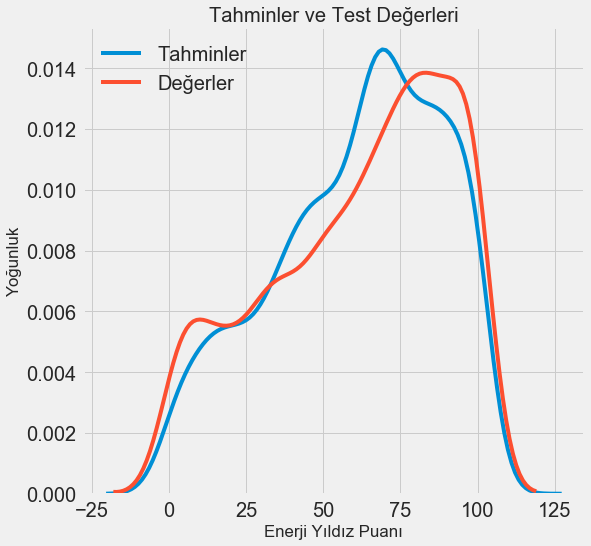

In [34]:
figsize(8, 8)

# Test verileri üzerinde final tahminler ve yoğunluk grafiği
sns.kdeplot(final_pred, label = 'Tahminler')
sns.kdeplot(y_test, label = 'Değerler')

# Çizimin etiketleri
plt.xlabel('Enerji Yıldız Puanı'); 
plt.ylabel('Yoğunluk');
plt.title('Tahminler ve Test Değerleri');

Dağılım, tahmin edilen değerlerin yoğunluğunun, 100 değerindeki gerçek zirveden ziyade test değerlerinin ortancaya yakın olmasına rağmen, neredeyse aynı görünmektedir. Görünüşe göre, model, aşırı değerleri tahmin etmede daha az doğru olabilir ve bunun yerine değerleri tahmin eder. medyan daha yakın.

Diğer bir tanı planı, artıkların histogramıdır. İdeal olarak, artıkların normal olarak dağılmasını umarız, yani modelin her iki yönünde de aynı miktarda yanlış olmasını bekleriz.

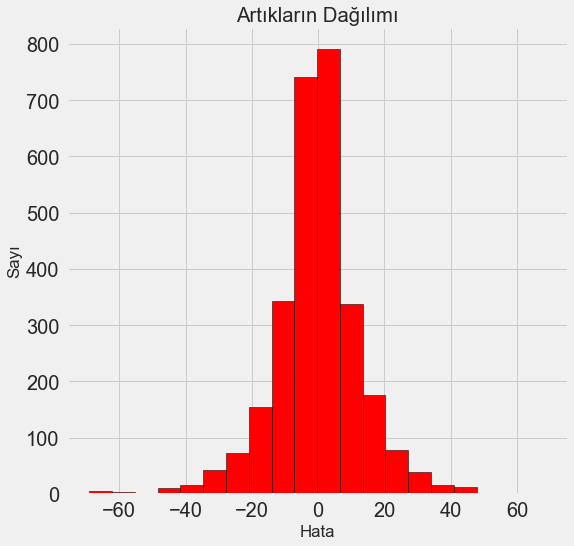

In [35]:
figsize = (6, 6)

# Kalıntıları hesaplıyoruz(residual)
residuals = final_pred - y_test

# Kalıntıların histogramını çizdiriyoruz
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Hata'); 
plt.ylabel('Sayı')
plt.title('Artıkların Dağılımı');

Kalıntılar, normal dağılıma yakındır, düşük uçta birkaç fark edilebilir aykırı durumlar olabilir. Bunlar, model tahmininin gerçek değerin çok altında olduğu hataları gösterir.

### Sonuç 
Bu çalışmamızda, makine öğrenme  aşamalarının önemli kavramlarını ele aldık:

  - Eksik değerlerin eklenmesi
  - Çeşitli makine öğrenme yöntemlerinin değerlendirilmesi ve karşılaştırılması
  - Rasgele arama ve çapraz doğrulama kullanarak bir makine öğrenme modeli için hiperparametre ayarlama
  - Test setindeki en iyi modelin değerlendirilmesi

Sonuçlar bize, makine öğreniminin problemimize uygulanabileceğini, son modelin bir binanın Enerji Yıldızı Puanını 9.1 puan olarak tahmin edebildiğini gösterdi. Ayrıca, hyperparamter tuning'in, modelin performansını iyileştirmek için zaman harcadığı ve zaman açısından önemli bir maliyete sahip olduğunu da gördük. Bu, uygun özellik mühendisliğinin ve daha fazla veri toplamanın (mümkünse!) modelin ince ayarından çok daha büyük bir ödeme yapmasının iyi bir hatırlatıcısıdır. Makine öğrenim modellerini tasarlarken göz önünde bulundurmamız gereken pek çok faktörden biri olan, zamana karşı çalışma zamanındaki doğruluğu da gözlemledik.

Modelimizin doğru olduğunu biliyoruz, ancak tahminlerin neden yapıldığını biliyor muyuz? Makine öğrenim sürecindeki bir sonraki adım çok önemlidir: modelin tahminleri nasıl yaptığını anlamaya çalışmak ve yüksek doğruluk elde etmek harikadır, ancak modelin neden doğru bir şekilde tahmin edilebileceğini anlayabildik mi, bu bilgiyi problemi daha iyi anlamak için kullanabileceğimiz konusunda da yardımcı olabiliriz. Örneğin, model Enerji Yıldızı Puanını bulmak için hangi özelliklere güveniyor? Bu modeli özellik seçimi için kullanmak ve daha yorumlanabilir olan daha basit bir model uygulamak mümkün mü?

Son çalışmamızda, bu soruları yanıtlamaya ve projeden nihai sonuçları çıkarmaya çalışacağız!